In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso

# Pre-processing

## Load data

In [62]:
negative_serology = ["SRR22402286","SRR22402358","SRR22402336","SRR22402315","SRR22402330","SRR22402374","SRR22402370","SRR22402355","SRR22402353","SRR22402352","SRR22402351","SRR22402350","SRR22402349","SRR22402384","SRR22402297","SRR22402275","SRR22402318","SRR22402347","SRR22402383","SRR22402317","SRR22402304","SRR22402371","SRR22402264","SRR22402365","SRR22402369","SRR22402368","SRR22402367","SRR22402366","SRR22402364","SRR22402292","SRR22402299","SRR22402291","SRR22402305","SRR22402277","SRR22402270","SRR22402265","SRR22402259","SRR22402258","SRR22402327","SRR22402319","SRR22402310","SRR22402306","SRR22402303","SRR22402328","SRR22402332","SRR22402331","SRR22402266","SRR22402307","SRR22402333","SRR22402329"]
X = pd.read_csv("../family_features.csv", sep=";")
# filter out samples with negative TG serology
X = X.loc[~X["Sample"].isin(negative_serology)]
y = pd.read_csv("../../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
X.shape

(122, 500)

In [63]:
y.value_counts()

Label
0    86
1    36
Name: count, dtype: int64

## Remove features with less than n% unique values

In [56]:
# Calculate the percentage of unique values for each feature
unique_percentages = (X.nunique() / X.shape[0]) * 100

# Identify features with more than 90% same values
features_to_drop = unique_percentages[unique_percentages < 90].index

# Remove the identified features from the DataFrame
filtered_X = X.drop(features_to_drop, axis=1)
filtered_X.shape

(122, 246)

## Split the data

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

## Logistic LASSO regression

In [58]:
lasso_pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0)),
    ('log_transform', FunctionTransformer(np.log1p)),
    ('lasso', Lasso(alpha=0.1))
])

In [59]:
# define the hyperparameters to search over
lasso_param_grid = {
    'lasso__alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    # 'logreg__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

# perform grid search to find the best hyperparameters
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid=lasso_param_grid, cv=10, n_jobs=-1)
# Fit the GridSearchCV object on the training data
lasso_grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions on the testing data
best_estimator = lasso_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Calculate regression metrics, e.g., mean squared error (MSE), R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
lasso_grid_search.best_params_

Mean Squared Error: 0.2354888382765602
R-squared: -0.08220973472683912


{'lasso__alpha': 0.1}

## Logistic regression

In [64]:
pipeline = Pipeline([
    ('variance_filter', VarianceThreshold(threshold=0)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),  # ANOVA feature selection with k=10
    ('log_transform', FunctionTransformer(np.log1p)),
    ('min_max_scale', MinMaxScaler()),
    ('logreg', LogisticRegression(max_iter=150,random_state=42))
])

Accuracy: 0.56
Best score:  0.7731578947368422


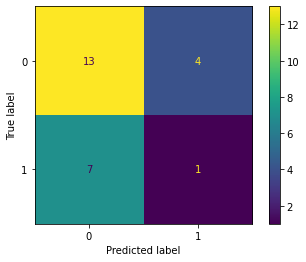

{'logreg__C': 1}

In [65]:
# define the hyperparameters to search over
param_grid = {
    'logreg__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print('Best score: ', grid_search.best_score_)

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_

## Random forest

In [46]:
# Define the Pipeline
rf_pipeline = Pipeline([
    # ('variance_filter', VarianceThreshold()), # Step 0: filter out variables with variance < threshold
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('min_max_scaler', MinMaxScaler()),  # Step 2: min-max scaling
    ('pca', PCA()),  # Step 3: PCA
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])

In [49]:
# #Define the parameter grid for grid search
rf_param_grid = {
    # 'variance_filter__threshold': [0.0, 0.1, 0.2, 0.3, 0.4], # grid search value for variance filter threshold
    'pca__n_components': [1, 5, 10, 15, 20, 25, 30],  # Step 3:grid search number of components
    'rf__n_estimators': [100, 150, 200, 250, 300, 350],  # Step 4: grid search for n_estimators
    'rf__max_depth': [25, 50, 100, 200, 250, 300, None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}
# rf_param_grid = {
#     # 'variance_filter__threshold': [0.1], # grid search value for variance filter threshold
#     'pca__n_components': [1],  # Step 3:grid search number of components
#     'rf__n_estimators': [1],  # Step 4: grid search for n_estimators
#     'rf__max_depth': [1],  # Step 4: grid search for max_depth
#     'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
#     'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
# }

# Define the GridSearchCV object
rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
rf_grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions on the testing data
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred,output_dict=True)
params = rf_grid_search.best_params_


# print("Accuracy:", accuracy)
print("Classification report:", report)
print("Best score:", rf_grid_search.best_score_)


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
rf_grid_search.best_params_